In [1]:
import findspark
findspark.init("C:\Spark")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [3]:
# Carregar os dados
movies = pd.read_csv('../data/movies.csv')
tags = pd.read_csv('../data/tags.csv')
ratings = pd.read_csv('../data/ratings.csv')

In [4]:
# Verificar as primeiras linhas de cada dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [7]:
# Informações sobre os DataFrames
movies.info()
print("-"*40)
tags.info()
print("-"*40)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328315 entries, 0 to 2328314
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 71.1+ MB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(

# Distribuição de Avaliações

Quantas avaliações cada filme recebeu? Qual a média das avaliações?

In [8]:
# Calcular o número de avaliações por filme
ratings_count = ratings.groupby('movieId').size()
ratings_count = ratings_count.rename('total_ratings')

# Calcular a média das avaliações por filme
average_ratings = ratings.groupby('movieId')['rating'].mean()
average_ratings = average_ratings.rename('average_rating')

# Criar DataFrame com as estatísticas dos filmes
movie_stats = pd.DataFrame({'Total Ratings': ratings_count, 'Average Rating': average_ratings})

# Unir movie_stats com movies para incluir o título do filme
movie_stats = movie_stats.merge(movies[['movieId', 'title']], on='movieId', how='left')

# Ordenar os filmes pelo número total de avaliações
movie_stats = movie_stats.sort_values(by='Total Ratings', ascending=False)

# Exibir as estatísticas dos filmes com títulos
movie_stats.head()

,movieId,Total Ratings,Average Rating,title
314,318,122296,4.416792,"Shawshank Redemption, The (1994)"
351,356,113581,4.068189,Forrest Gump (1994)
292,296,108756,4.191778,Pulp Fiction (1994)
2480,2571,107056,4.160631,"Matrix, The (1999)"
585,593,101802,4.150287,"Silence of the Lambs, The (1991)"


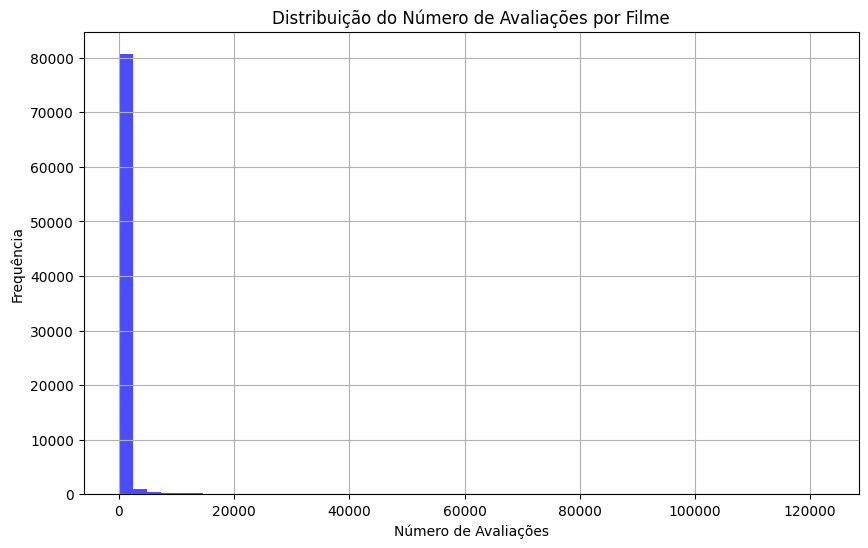

In [9]:
# Histograma do número de avaliações por filme
plt.figure(figsize=(10, 6))
plt.hist(movie_stats['Total Ratings'], bins=50, color='blue', alpha=0.7)
plt.title('Distribuição do Número de Avaliações por Filme')
plt.xlabel('Número de Avaliações')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

**Distribuição do Número de Avaliações por Filme**: O histograma mostra uma distribuição altamente concentrada de avaliações em um pequeno número de filmes, com a grande maioria dos filmes recebendo poucas avaliações. Isso é típico em muitos sistemas de recomendação, onde alguns filmes populares recebem uma grande quantidade de atenção (avaliações), enquanto a maioria recebe pouca atenção.

# Filmes mais Populares

Quais são os filmes com mais avaliações? Isso pode ser um indicativo de popularidade?

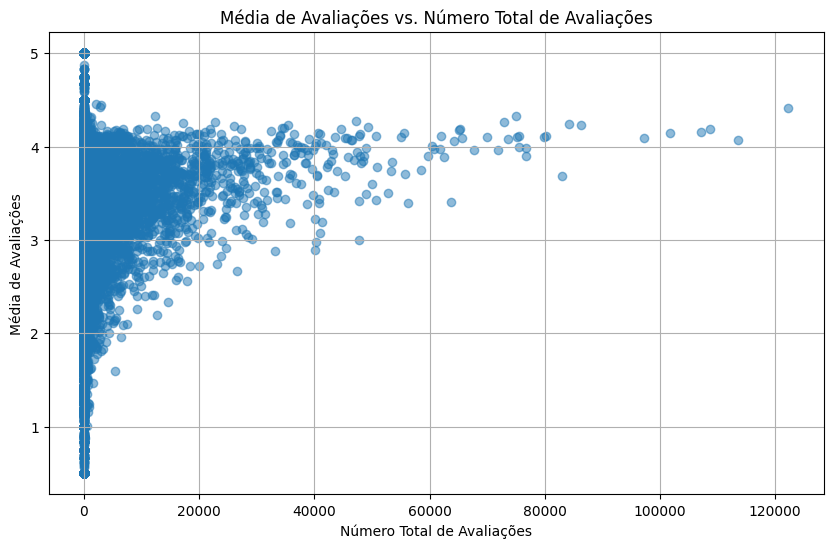

In [10]:
# Scatter plot da média de avaliações versus número total de avaliações
plt.figure(figsize=(10, 6))
plt.scatter(movie_stats['Total Ratings'], movie_stats['Average Rating'], alpha=0.5)
plt.title('Média de Avaliações vs. Número Total de Avaliações')
plt.xlabel('Número Total de Avaliações')
plt.ylabel('Média de Avaliações')
plt.grid(True)
plt.show()

**Média de Avaliações vs. Número Total de Avaliações**: O scatterplot mostra uma tendência interessante: filmes com um número muito alto de avaliações tendem a ter médias de avaliação mais moderadas (em torno de 3 a 4). Há uma concentração densa de pontos perto do eixo y, indicando que muitos filmes com poucas avaliações têm médias que variam amplamente de 1 a 5. Isso pode sugerir que filmes menos avaliados possuem avaliações mais polarizadas (ou seja, as pessoas tendem a avaliá-los ou muito positivamente ou muito negativamente), enquanto filmes mais populares e frequentemente avaliados tendem a ter avaliações mais balanceadas, talvez devido a uma maior diversidade de opiniões dos espectadores.

### Possível Conclusão :
- **Popularidade vs. Qualidade Percebida**: Os filmes mais avaliados não necessariamente têm as avaliações mais altas, o que pode indicar que a popularidade (número de avaliações) não é diretamente proporcional à qualidade percebida (média das avaliações).
- **Impacto dos Outliers**: Filmes com poucas avaliações podem ter médias de avaliações extremamente altas ou baixas, o que pode ser o resultado de um número menor de opiniões não representando a opinião geral.
- **Estratégias para Sistemas de Recomendação**: Para um sistema de recomendação, esses insights podem ser usados para ponderar como as recomendações são feitas, talvez dando mais peso a filmes com um número razoável de avaliações moderadamente altas, ao invés de apenas sugerir filmes com poucas avaliações muito altas ou muitas avaliações muito variadas.

# Análise de Tags

Quais tags são mais comuns? Como as tags estão distribuídas entre os filmes?

In [11]:
# Contar a frequência de cada tag
tag_counts = tags['tag'].value_counts()

# Exibir as 10 tags mais comuns
print("As 10 tags mais comuns:")
print(tag_counts.head(10))

# Calcular quantos filmes diferentes têm cada tag
tags_per_movie = tags.groupby('tag')['movieId'].nunique()

# Ordenar as tags pelo número de filmes diferentes que a utilizam
tags_per_movie_sorted = tags_per_movie.sort_values(ascending=False)

# Exibir as 10 tags usadas por mais filmes diferentes
print("\n10 tags usadas por mais filmes diferentes:")
print(tags_per_movie_sorted.head(10))

As 10 tags mais comuns:
sci-fi                14319
atmospheric           12172
action                10683
comedy                10161
surreal                9142
funny                  9094
visually appealing     8890
twist ending           8325
thought-provoking      7727
dark comedy            7659
Name: tag, dtype: int64

10 tags usadas por mais filmes diferentes:
tag
BD-R                3948
murder              3782
woman director      3602
independent film    2858
violence            2291
comedy              1983
death               1938
drama               1879
friendship          1809
revenge             1771
Name: movieId, dtype: int64


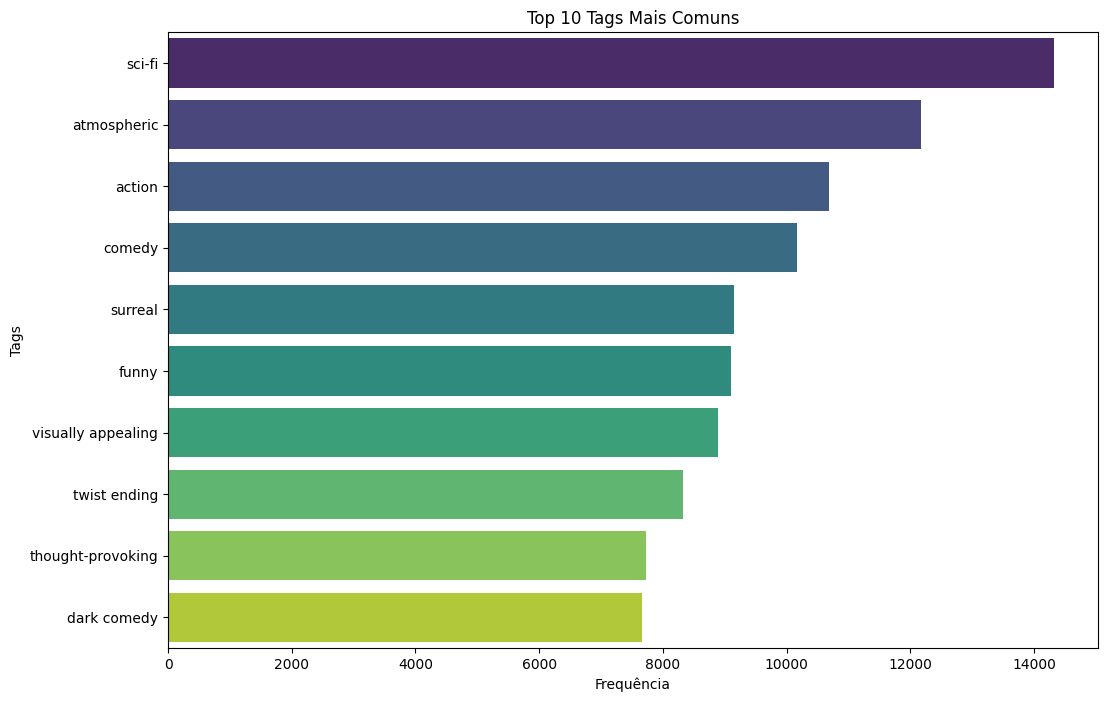

In [12]:
# Gráfico de barras para as 10 tags mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(x=tag_counts.head(10).values, y=tag_counts.head(10).index, palette="viridis")
plt.title('Top 10 Tags Mais Comuns')
plt.xlabel('Frequência')
plt.ylabel('Tags')
plt.show()

**Preferências Temáticas**: As tags mais comuns revelam que temas como "sci-fi", "atmospheric", e "action" são muito populares entre os usuários do MovieLens. Isso sugere que esses gêneros têm uma base de fãs considerável que se sente motivada a taggear esses filmes.

**Diversidade de Interesses**: A variedade nas tags top 10, que inclui "comedy", "surreal", "funny", "visually appealing", "twist ending", "thought-provoking", e "dark comedy", indica que os usuários estão interessados numa ampla gama de qualidades de filmes, desde o gênero até características mais específicas como o tipo de enredo ou estilo visual.

**Engajamento do Usuário**: A presença de tags detalhadas e descritivas como "thought-provoking" e "twist ending" mostra que os usuários estão engajados com os filmes a um nível que vai além do simples entretenimento, destacando a capacidade dos filmes de provocar reflexão ou surpreender com reviravoltas no enredo.

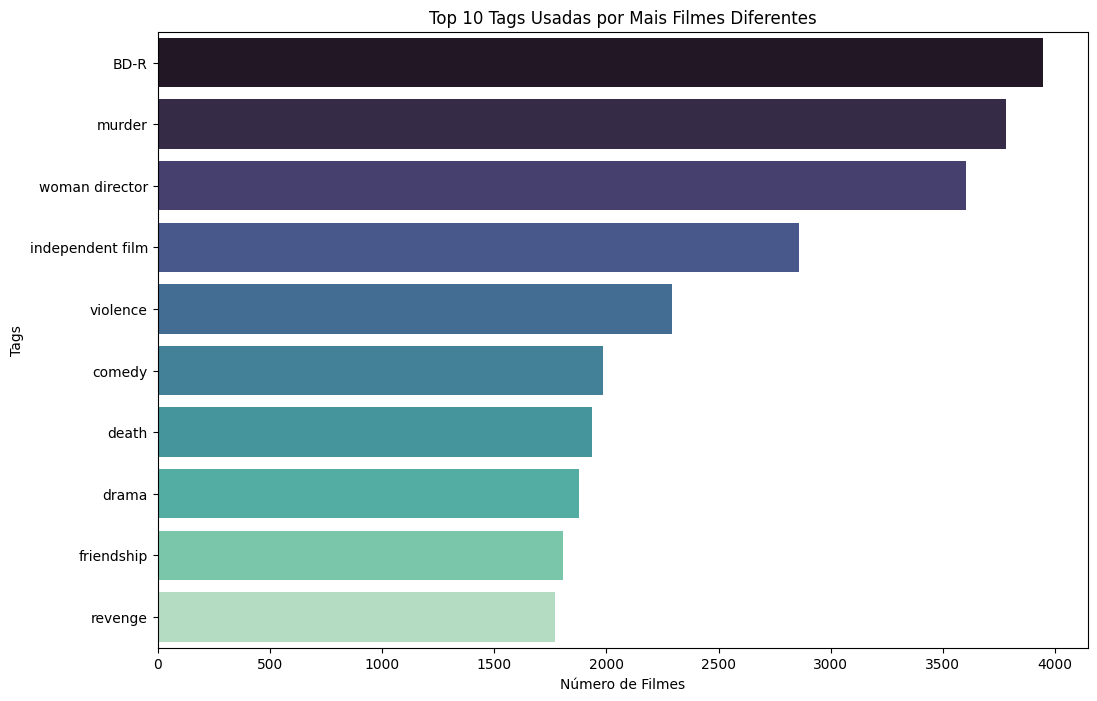

In [13]:
# Gráfico de barras para as 10 tags usadas por mais filmes diferentes
plt.figure(figsize=(12, 8))
sns.barplot(x=tags_per_movie_sorted.head(10).values, y=tags_per_movie_sorted.head(10).index, palette="mako")
plt.title('Top 10 Tags Usadas por Mais Filmes Diferentes')
plt.xlabel('Número de Filmes')
plt.ylabel('Tags')
plt.show()

**Tags de Amplo Uso**: Tags como "BD-R", "murder", "woman director" e "independent film" lideram em termos de serem aplicadas a muitos filmes diferentes. A tag "BD-R" pode ser uma anomalia ou erro de entrada de dados, já que não é uma descrição comum de conteúdo de filme. Tags como "murder" e "woman director" são mais generalizáveis e podem ser aplicadas a uma ampla gama de filmes.

**Foco em Conteúdo e Produção**: Tags como "independent film", "violence", "comedy", "death", "drama", "friendship", e "revenge" indicam um foco dos usuários tanto no conteúdo temático dos filmes quanto em aspectos da produção (como "independent film" e "woman director"). Isso mostra que os usuários estão conscientes dos contextos de produção dos filmes além de seus temas.

**Conscientização Social**: As tags "woman director" e "independent film" serem algumas das mais usadas sugere uma crescente conscientização e valorização da representatividade feminina na direção de filmes, bem como um reconhecimento do valor dos filmes independentes. Isso reflete talvez um movimento mais amplo dentro da comunidade de cinéfilos para reconhecer e apoiar a diversidade e a originalidade na indústria cinematográfica.

# Formatando os dados para o modelo

### Reduzindo o uso de memória

In [14]:
# Convertendo tipo de dados
tags['movieId'] = tags['movieId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['userId'] = ratings['userId'].astype('int32')

# Descartando colunas desnecessárias
ratings = ratings.drop(columns=['timestamp'])
tags = tags.drop(columns=['timestamp'])

In [15]:
# Salvando os dados tratados de volta para arquivos CSV
#tags.to_csv('../data/tags_cleaned.csv', index=False)
#ratings.to_csv('../data/ratings_cleaned.csv', index=False)

In [16]:
# Iniciar a Spark Session
spark = SparkSession.builder \
    .appName("Movie Data Processing") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Carregar os dados
movies_df = spark.read.csv('../data/movies.csv', header=True, inferSchema=True)
ratings_df = spark.read.csv('../data/ratings_cleaned.csv', header=True, inferSchema=True)
tags_df = spark.read.csv('../data/tags_cleaned.csv', header=True, inferSchema=True)

# Realizar o join entre movies e ratings primeiro
movies_ratings = movies_df.join(ratings_df, 'movieId', 'inner')

# Realizar o join entre o resultado anterior e tags usando tanto 'movieId' quanto 'userId'
full_data = movies_ratings.join(tags_df, ['movieId', 'userId'], 'inner')

# Exibir os primeiros registros do DataFrame
full_data.show(5)

+-------+------+----------------+--------------------+------+-------------+
|movieId|userId|           title|              genres|rating|          tag|
+-------+------+----------------+--------------------+------+-------------+
|      1|  2483|Toy Story (1995)|Adventure|Animati...|   4.0|lots of heart|
|      1| 31107|Toy Story (1995)|Adventure|Animati...|   3.0|    animation|
|      1| 31107|Toy Story (1995)|Adventure|Animati...|   3.0|       family|
|      1| 31107|Toy Story (1995)|Adventure|Animati...|   3.0|       sci-fi|
|      1| 82148|Toy Story (1995)|Adventure|Animati...|   4.0|   Animation |
+-------+------+----------------+--------------------+------+-------------+
only showing top 5 rows



# Tratamento das Features

In [17]:
# Verificar a existência de valores nulos nas colunas relevantes
print("Contagem de Nulos antes da limpeza:")
for col in full_data.columns:
    print(col, ":", full_data.filter(full_data[col].isNull()).count())

Contagem de Nulos antes da limpeza:
movieId : 0
userId : 0
title : 0
genres : 0
rating : 0
tag : 2


In [18]:
# como temos poucos valores nulos, vamos simplesmente descartá-los
full_data = full_data.dropna()

In [19]:
# Converter o DataFrame do Spark para o DataFrame do Pandas
pandas_df = full_data.toPandas()

In [22]:
pandas_df.head()

,movieId,userId,title,genres,rating,tag
0,1,2483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,lots of heart
1,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,animation
2,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,family
3,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,sci-fi
4,1,82148,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,Animation


In [23]:
# salvar em um arquivo CSV
pandas_df.to_csv('../data/full_data.csv', index=False)

In [24]:
# encerrar a Spark Session
spark.stop()